In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

from multiprocessing import Pool

%matplotlib inline

In [2]:
files = glob.glob("/scratch/04101/vvenu/SPARSE_TEST/epi/grid_vals/mws_grid*/*")

In [3]:
len(files)

2073600

In [4]:
def read_json(file):
    
    index = os.path.basename(file).split(".")[0]
    
    with open(file,"r") as f:
        try:
            result = json.load(f)
        except:
            result = None
    
    return result

In [5]:
def read_all(files):
    
    results = []
    
    with Pool() as pool:
        
        for i,result in enumerate(pool.imap_unordered(read_json,files)):
            if i % 100000 == 0:
                print(i)
            results.append(result)
        
    return results

In [ ]:
tets = read_json(files[-1])

In [ ]:
tets

In [6]:
results = read_all(files)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000


In [7]:
#convert to plottable values
for x in results:
    
#     if x is None: 
#         results.remove(x)
#         continue
    
    for item in x:
    
        if x[item] == None: x[item] = 0
        if x[item] == False: x[item] = 0
        if x[item] == True: x[item] = 1
        if type(x[item]) == list: x[item] = str(x[item])
        
        if type(x[item]) == dict:
            for it in x[item]:
      
                if x[item][it] == None: x[item][it] = 0
                if x[item][it] == False: x[item][it] = 0
                if x[item][it] == True: x[item][it] = 1
                if type(x[item][it]) == list: x[item][it] = str(x[item[it]])

In [8]:
best_results = results

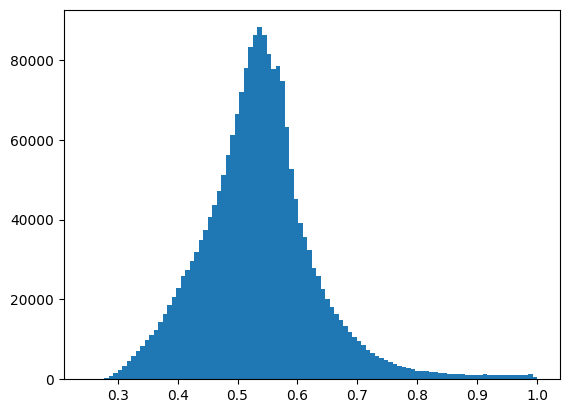

In [9]:
plt.hist([x['nvi_sum'] for x in best_results], bins=100);

In [10]:
best_results = sorted(best_results, key=lambda x: x["nvi_sum"])

In [ ]:
best_results[0]

In [11]:
to_avg = [
 'rand_split',
 'rand_merge',
 'voi_split',
 'voi_merge',
 'nvi_split',
 'nvi_merge',
 'nid',
 'voi_sum',
 'nvi_sum']

In [12]:
not_to_avg = [
 'roi',
 'raw_file',
 'labels_dataset',
 'labels_mask',
 'pred_file',
 'pred_dataset',
 'downsampling',
 'denoising',
 'normalize_preds',
 'stride',
 'algorithm',
 'pred_iteration',
 'affs_iteration',
 'sigma',
 'gb',
 'gt_type',
 'EA',
 'lite',
 'LR']
# not_to_avg = [
#  'raw_file',
#  'labels_dataset',
#  'labels_mask',
#  'pred_file',
#  'pred_dataset',
#  'roi',
#  'downsampling',
#  'denoising',
#  'normalize_preds',
#  'stride',
#  'algorithm']

In [13]:
for x in best_results:
    x['pred_iteration'] = int(x['pred_dataset'].split('_')[-1])
    x['affs_iteration'] = int(x['pred_dataset'].split('_')[-5])
    
    x['sigma'] = x['pred_file'].split('/')[-4]
    
    if '0gb' in x['pred_file']:
        x['gb'] = 0
    if '1gb' in x['pred_file']:
        x['gb'] = 1
    if '2gb' in x['pred_file']:
        x['gb'] = 2
    
    if 'arlo' in x['pred_file']:
        x['gt_type'] = "arlo"
    elif 'jan' in x['pred_file']:
        x['gt_type'] = "jan"
    else: x['gt_type'] = "voronoi"
        
    x["EA"] = "no" if "noEA" in x['pred_file'] else "yes"
    x["lite"] = "yes" if "lite" in x['pred_file'] else "no"
    x["LR"] = "yes" if "LR" in x['pred_file'] else "no"

In [14]:
#grouping across ROIs
all_rois = list(set(x['roi'] for x in best_results))
print(all_rois)

#results by roi
results_by_roi = {k:[x for x in best_results if x['roi'] == k] for k in all_rois}
print(list(zip(range(len(results_by_roi)),[len(x) for x in results_by_roi.values()])))

['[[0, 5625, 4500], [3525, 15000, 15000]]', '[[0, 22500, 22500], [3525, 15000, 15000]]', '[[0, 45000, 45000], [3525, 15000, 15000]]']
[(0, 691200), (1, 691200), (2, 691200)]


In [15]:
#find intersection of all arg combos among all rois
intersection = []
for roi in results_by_roi:
    intersection.append(
        [''.join([str(result[x]) for x in not_to_avg[1:]]) for result in results_by_roi[roi]]
    )
    
intersection = set.intersection(*map(set,intersection))

print(len(intersection))

691200


In [16]:
#filter results_by_roi using intersection
results_by_roi = {k:[x for x in results_by_roi[k] if ''.join([str(x[j]) for j in not_to_avg[1:]]) in intersection] for k in all_rois}
print(list(zip(range(len(results_by_roi)),[len(x) for x in results_by_roi.values()])))

[(0, 691200), (1, 691200), (2, 691200)]


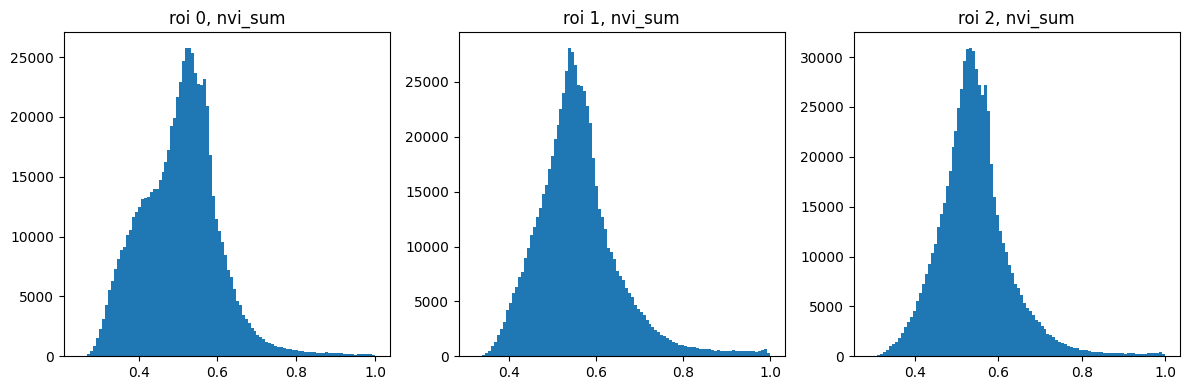

In [17]:
#plot metric for all rois
metric = 'nvi_sum'
rois_to_plot = all_rois

fig, axes = plt.subplots(1,len(rois_to_plot),figsize=(12,4),sharex=False,sharey=False,squeeze=False)

for i,roi in enumerate(rois_to_plot):
    
    axes[0][i].hist([x[metric] for x in results_by_roi[roi]],bins=100)
    axes[0][i].set_title(f"roi {i}, {metric}")
    
plt.tight_layout()

In [18]:
#AVERAGE across rois.
results_roi_avg = []

for i,result in enumerate(results_by_roi[all_rois[0]]):

    averaged = {}

    for key in not_to_avg[1:]:
        averaged[key] = result[key]

    #good thing order is preserved
    parts = [results_by_roi[x][i] for x in all_rois]

    #print(len(parts))
    assert len(parts) == len(all_rois)

    for key in to_avg:
        vals = [x[key] for x in parts]
        averaged[key] = [np.mean(vals),np.std(vals)]

    results_roi_avg.append(averaged)

In [19]:
results_roi_avg = sorted(results_roi_avg, key=lambda x: x["nvi_sum"])#[0] - x["nvi_sum"][1])

In [40]:
#plot a selection
results_to_plot = [x for x in results_roi_avg \
                    #if x['background_mask']==0
                    if x['nvi_sum'][0] < 0.45 \
                    #and x['nid'][0] < 0.2 \
                    and 'sigma' not in x['sigma']
                  ]
len(results_to_plot)

142

In [41]:
results_to_plot[0]

{'raw_file': '/scratch/04101/vvenu/SPARSE_TEST/epi/data/test.zarr',
 'labels_dataset': 'labels',
 'labels_mask': 0,
 'pred_file': '/scratch/04101/vvenu/SPARSE_TEST/epi/affs_nets/affs_0/LR_EA_0gb_heavy/jan/2d_test.zarr',
 'pred_dataset': '3d_affs_4000_from_stacked_affs_10000',
 'downsampling': 0,
 'denoising': "['tv', 0.05, 0]",
 'normalize_preds': 1,
 'stride': '[1, 4, 4]',
 'algorithm': 'kruskal',
 'pred_iteration': 10000,
 'affs_iteration': 4000,
 'sigma': 'affs_0',
 'gb': 0,
 'gt_type': 'jan',
 'EA': 'yes',
 'lite': 'no',
 'LR': 'yes',
 'rand_split': [0.6878586333418504, 0.16887421254118293],
 'rand_merge': [0.5326970520238368, 0.2144955908531385],
 'voi_split': [1.8028978942053258, 1.038508172818632],
 'voi_merge': [1.2336307306626066, 0.5456953677770727],
 'nvi_split': [0.23810359816967916, 0.10418858186679954],
 'nvi_merge': [0.18706557623968845, 0.1021869497956255],
 'nid': [0.34369827996315455, 0.0633570552352302],
 'voi_sum': [3.0365286248679326, 0.5886249861843893],
 'nvi_sum

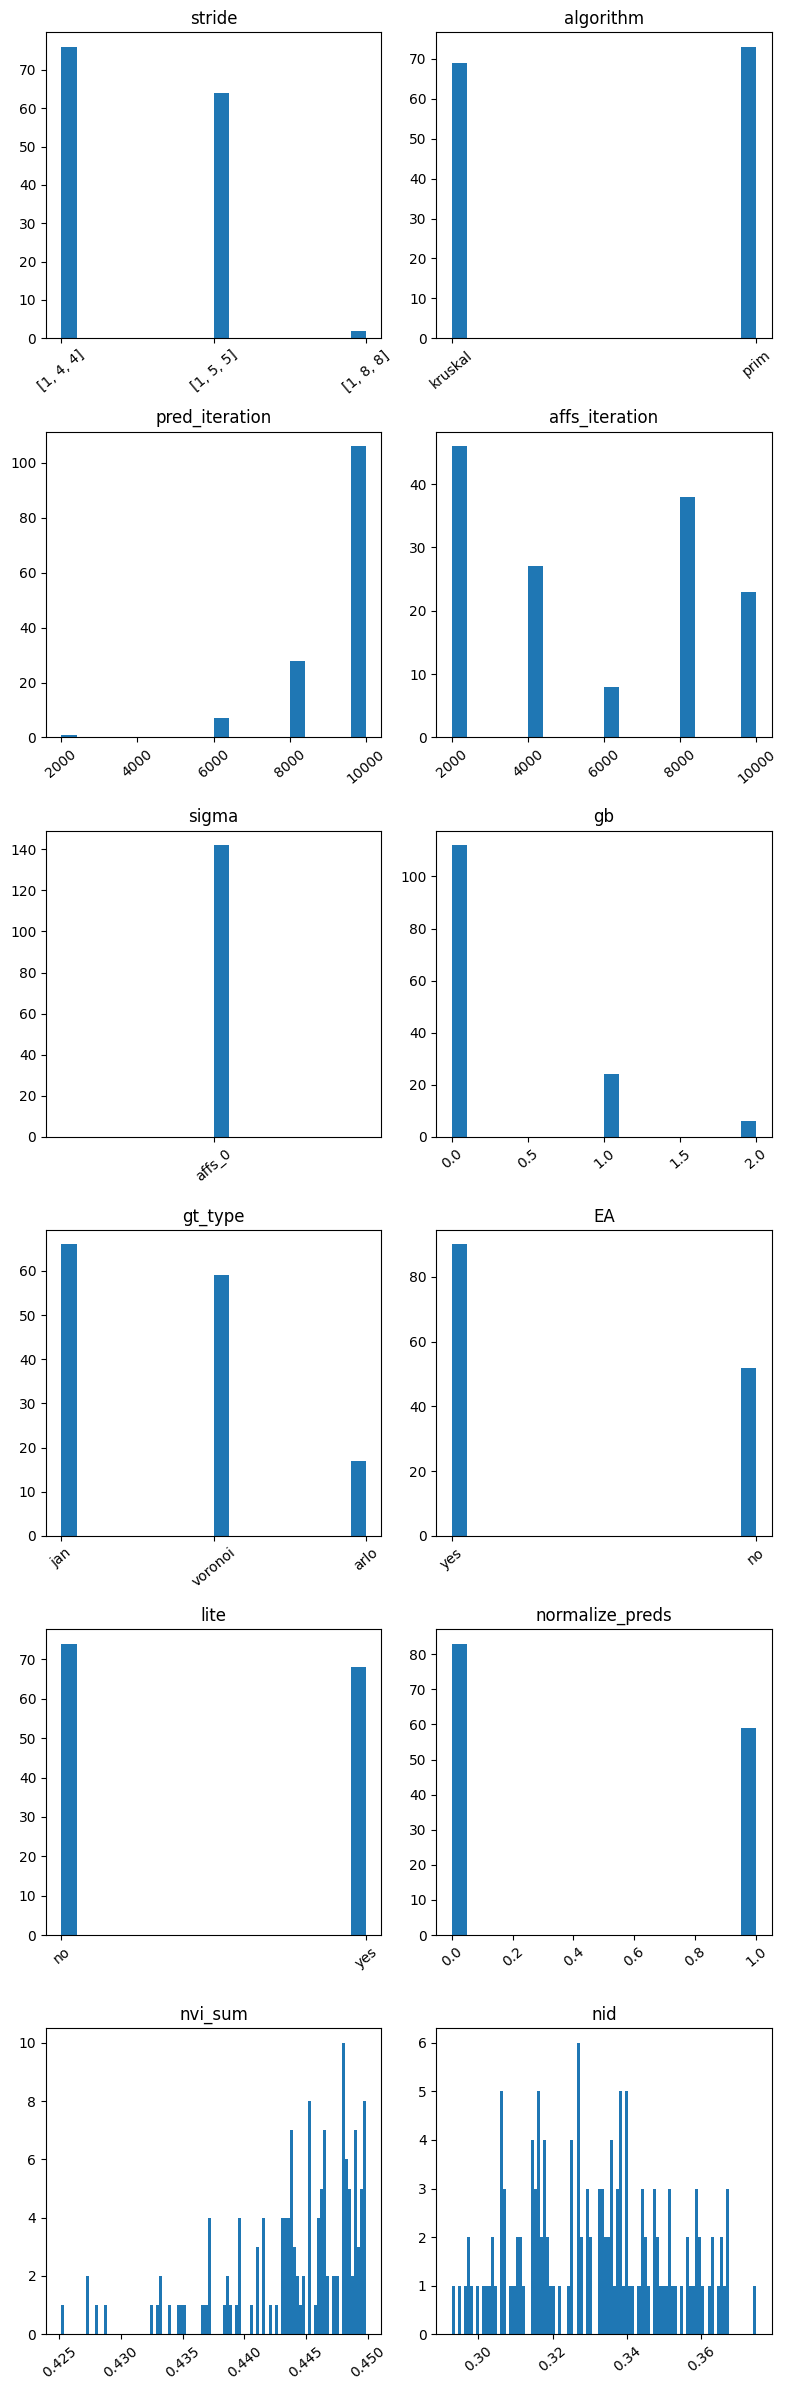

In [42]:
#plot histograms
fig, axes = plt.subplots(6,2,figsize=(8,24),sharex=False,sharey=False,squeeze=False)

row = 0

for plot_num,plot_name in enumerate(
    [
        'stride',
        'algorithm',
        'pred_iteration',
        'affs_iteration',
        'sigma',
        'gb',
        'gt_type',
        'EA',
        'lite',
        'normalize_preds',
        'nvi_sum',
        'nid'
    ]):
    
    if plot_name in to_avg:
        data = [x[plot_name][0]  for x in results_to_plot]
        nbins = 100
    else:
        data = [x[plot_name] for x in results_to_plot]
        nbins = 20
    
    axes[row][plot_num % 2].hist(data,bins=nbins)
    axes[row][plot_num % 2].set_title(plot_name)
    axes[row][plot_num % 2].tick_params(axis='x', rotation=40)
    
    if plot_num % 2 == 1:
        row += 1
        
plt.tight_layout()